<a href="https://colab.research.google.com/github/sanjeesi/Notes-Notebooks/blob/master/Data%20Science%20IITM/MLP/Week3/LinearRegression_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with sklearn API
The objective of this colab is to demonstrate how to build a linear regression model with `sklearn`. We will be using the following set up:
1. Dataset: California housing
2. Linear regression API: `LinearRegression`
3. Training: `fit` (normal equation) and `cross_validation` (normal equation with cross validation).
4. Evaluation: `score` (r2 score) and `cross_val_score` with different scoring parameters.

We will study the model diagnosis with `LearningCurve` and learn how to examine the learned model or weight vector.

In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
np.random.seed(306)
plt.style.use('seaborn')

We will use `ShuffledSplit` cross validation with:
- 10 folds (`n_split`) and
- set aside 20% examples as test examples (`test_size`)

In [7]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Creates 10 folds through shuffle split by keeping aside 20% examples as test in each fold.

## Step #1: Load the dataset

In [10]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

In [11]:
print('Shape of feature matrix: ', features.shape)
print('Shape of label vector: ', labels.shape)

Shape of feature matrix:  (20640, 8)
Shape of label vector:  (20640,)


As a sanity check, make sure that the number of rows in feature matrix and labels match.

In [12]:
assert(features.shape[0] == labels.shape[0])

## Step #2: Data exploration
Data exploration has been covered in [Introduction to Scikit-Learn](https://github.com/sanjeesi/Notes-Notebooks/blob/master/Data%20Science%20IITM/MLP/Week1/Introduction%20to%20Scikit-Learn.ipynb) notebook.

## Step #3: Preprocessing and model building
### 3.1 Train test split
The first step is to split the training data into training and test set. We do not access the test data till the end. All data exploration and tuning is perfomed on the training set and by setting aside a small portion of training as a dev or validation set.

In [13]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

In [14]:
print("# of training samples: ", train_features.shape[0])
print("# of test samples: ", test_features.shape[0])

# of training samples:  15480
# of test samples:  5160


In [15]:
# Sanity check
assert(train_features.shape[0] == train_labels.shape[0])
assert(test_features.shape[0] == test_labels.shape[0])

### 3.2 Pipeline: preprocessing + model
As a first step, build linear regression models with default parameter setting of `LinearRegerssion` APIs.
> We will make use of `Pipeline` API for combining data preprocessing and model building.
We will use `StandardScaler` feature scaling to bring all features on the same scale followed by a `LinearRegression` model.

In [18]:
# set up the linear regression model.
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])

# train linear regression model with normal equation.
lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now that we have trained the model, let's check the learnt/estimated weight vectors (`intercept_` and `coef_`).

In [21]:
# we can access the 'LinearRegression' object as 'lin_reg_pipeline[-1] which is the last step in the pipeline.
print('intercept (w_0): ', lin_reg_pipeline[-1].intercept_)
print('weight vector (w_1, ... , w_m: ', lin_reg_pipeline[-1].coef_)

intercept (w_0):  2.0703489205426377
weight vector (w_1, ... , w_m:  [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


## Step #4: Model Evaluation
#### `Score`
Let's use `score` method to obtain train and test errors with twin objectives:
- Estimation of model performance as provided by test error.
- Comparision of errors for model dignostice purpose (under/over/just right fit)

In [22]:
# evaluate model performance on the test set.
test_score = lin_reg_pipeline.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

train_score = lin_reg_pipeline.score(train_features, train_labels)
print("Model performace on train set: ", train_score)

Model performance on test set:  0.5910509795491352
Model performace on train set:  0.609873031052925


The `score` method returns `r2` score whose best value is 1. The `r2` scores on training and test are comparable but they are not that high. It points to underfitting issue in model training.

#### Cross validated score (`cross_val_score`)
Since the `score` was computed on one fold that was selected as a test set, it may not be all that robust. In order to obtain robust estimate of the performance, we use `cross_val_score` that calculates `score` on different test folds through cross validation.

In [24]:
lin_reg_score = cross_val_score(lin_reg_pipeline,
                                train_features,
                                train_labels,
                                scoring='neg_mean_squared_error',
                                cv=shuffle_split_cv)
# This will return 10 different scores, one for each fold.
print(lin_reg_score)

# We can take mean and standard deviation of the score and report it.
print(f"\nScore of linear regression model on the test set:\n"
      f"{lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}")

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score of linear regression model on the test set:
-0.529 +/- 0.022


Here we got the negative mean squared error as a **score**. We can convert that to **error** as follows:

In [25]:
lin_reg_mse = -lin_reg_score
print(f"\n MSE of linear regression model on the test set:\n"
      f"{lin_reg_mse.mean():.3f} +/- {lin_reg_mse.std():.3f}")


 MSE of linear regression model on the test set:
0.529 +/- 0.022


We can use other `scoring` parameters and obtain cross validated scores based on that parameter. The following choices are available for `scoring`:
- explained_variance
- max_error
- neg_mean_absolute_error
- neg_root_mean_squared_error
- neg_mean_squared_log_error
- neg_median_absolute_error
- neg_mean_absolute_percentage_error
- r2

### Cross Validation
We just calculated `cross_val_score` based on the cross validation. It however returns only scores for each fold. What if we also need to access the models trained in each fold along with some other statistics like train error for that fold?
> `cross_validate` API enables us to obtain them.

In [26]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    train_features,
                                    train_labels,
                                    cv=shuffle_split_cv,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True,
                                    return_estimator=True)

The `lin_reg_cv_result` is a dictionary with the following contents:
- trained `estimators`,
- time taken for fitting (`fit_time`) and scoring (`score_time`) the models in cross validation,
- `train_score` and
- `test_score`

In [27]:
lin_reg_cv_results

{'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]

There are 10 values in each dictionary key. That is because of `cv=10` or 10-fold cross validation that we used.  

Let's compare training and test errors.  
> Multiply the scores by -1 and convert tham to errors.

In [28]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f"\n MSE of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")
print(f"\n MSE of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")


 MSE of linear regression model on the train set:
0.519 +/- 0.006

 MSE of linear regression model on the test set:
0.529 +/- 0.022


- The training and test errors are high, which is an indication of underfitting, which we will confirm by plotting the learning curves.
- Test error has higher variability across different folds compared to the train error.

### Effect of training set size on error
Let's understand how the training set size or #samples affect the error. We can use `learning_curve` API that calculates cross validation scores for different #samples as specified in its argument `train_sizes`.

In [39]:
#@title [Plot leaning curves]
def plot_learning_curve(train_sizes, train_scores, test_scores):
  train_scores_mean = np.mean(-train_scores, axis=1)
  train_scores_std = np.std(-train_scores, axis=1)
  test_scores_mean = np.mean(-test_scores, axis=1)
  test_scores_std = np.std(-test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)

  plt.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color='r',)
  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean - test_scores_std,
      alpha=0.1,
      color='g',)
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', linewidth=2)
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', linewidth=2)
  plt.xlabel('Training examples')
  plt.ylabel('MSE')
  plt.legend(loc='best')

No handles with labels found to put in legend.


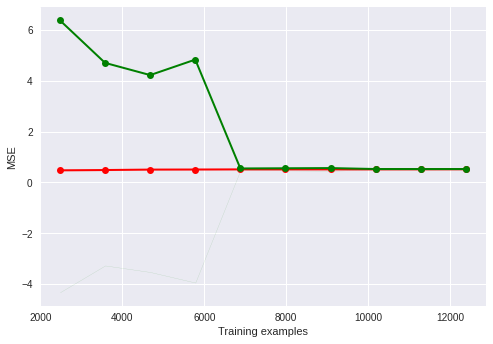

In [40]:
(train_sizes, train_scores, test_scores, fit_times, score_times) = \
  learning_curve(
      lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,
      scoring='neg_mean_squared_error', n_jobs=-1,
      return_times=True, train_sizes=np.linspace(0.2, 1.0, 10))
plot_learning_curve(train_sizes, train_scores, test_scores)

### Selecting best model
Let's select the model with the lowest cross validated test error as the best perfoming model.

In [42]:
# Let's find out the best model that resulted in the least test error.
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

Let's examine the model coefficients.

In [43]:
print('Intercept (w_0): ', selected_model['lin_reg'].intercept_)
print('Coefficients (w_1, ... ,w_m): ', selected_model['lin_reg'].coef_)

Intercept (w_0):  2.0779898917958657
Coefficients (w_1, ... ,w_m):  [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


### Model performance
Let's first obtain the predictions for test points in cross validation.

In [45]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(lin_reg_pipeline, train_features, train_labels)
# this API gives us scores for points when they were part of the test set in cross validation

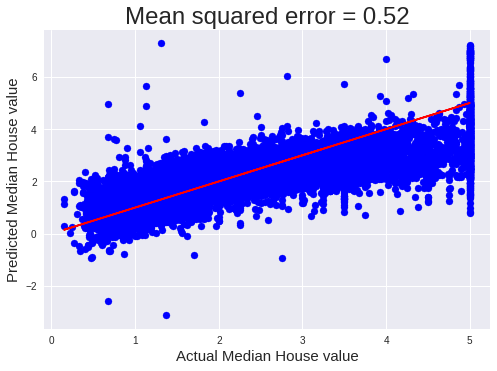

In [46]:
mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)
plt.xlabel('Actual Median House value', size=15)
plt.ylabel('Predicted Median House value', size=15)
plt.show()

- There are some negative predictions. We can fix this by adding a constraints on the weights to be positive.  
> At this stage, we should perform error analysis and check where the predictions are going wrong. We can revisit feature construction, preprocesssing or model stages and make the necessary course corrections to get better performance.

## Step #5: Predictions
We can use the best performing model from cross validation for getting predictions on the test set.

In [47]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

We can also obtain predictions using the initial model that we built without cross validation.

In [48]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

## Step #6: Report model performance
We report model performance on the test set.

In [49]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print("R2 score for the vest model obtained via cross validation: ", score_cv)
print("R2 score for model without cv: ", score)

R2 score for the vest model obtained via cross validation:  0.5923577635319088
R2 score for model without cv:  0.5910509795491352


Alternatively we can use any other metric of interest and report performance based on that. For example, the mean squared error is as follows:

In [50]:
mse = mean_squared_error(test_labels, test_predictions)
mse_cv = mean_squared_error(test_labels, test_predictions_cv)

print("MSE for the best model obtained via cross validation: ", mse_cv)
print("MSE for model without cv: ", mse)

MSE for the best model obtained via cross validation:  0.5393995876218523
MSE for model without cv:  0.5411287478470688


The cross validation based model has slightly lower MSE that the other model and hence better performance.